In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')
import plugins


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [2]:
# Simple code to test the implementation
bsdf = plugins.RednerMat(mi.Properties())
print(bsdf) # Show the default parameters

RednerMat[
    albedo=UniformSpectrum[value=[0.1]],
    roughness=UniformSpectrum[value=[0.1]],
    specular=UniformSpectrum[value=[0.1]],
]


In [3]:
# Simple test of eval, pdf and samples

# Test with fake intersection
si = dr.zeros(mi.SurfaceInteraction3f)
si.wi = mi.Vector3f([0, 0, 1])
ctx = mi.BSDFContext()

# Call eval, pdf, samples
print(bsdf.eval(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.pdf(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.sample(ctx, si, 0.5, mi.Point2f(0.5)))

[[0.11140845715999603, 0.11140845715999603, 0.11140845715999603]]
[0.5570423007011414]
(BSDFSample[
  wo = [[-0.49993, -4.37053e-08, 0.866066]],
  pdf = [0.351061],
  eta = [1],
  sampled_type = TODO,
  sampled_component = [0]
], [[0.20000004768371582, 0.20000004768371582, 0.20000004768371582]])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Code which will plot the eval and PDF distribution
def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

def plot_dist(values):
    """values needs to be an numpy float array"""
    values_r = values.reshape(2 * res, res).T

    # Plot values for spherical coordinates
    fig, ax = plt.subplots(figsize=(8, 4))

    im = ax.imshow(values_r, extent=[0, 2 * np.pi, np.pi, 0], cmap='jet')

    ax.set_xlabel(r'$\phi_o$', size=10)
    ax.set_xticks([0, dr.pi, dr.two_pi])
    ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
    ax.set_ylabel(r'$\theta_o$', size=10)
    ax.set_yticks([0, dr.pi / 2, dr.pi])
    ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);

si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(dr.deg2rad(45.0), 0.0)

# Create grid in spherical coordinates and map it onto the sphere
res = 300
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

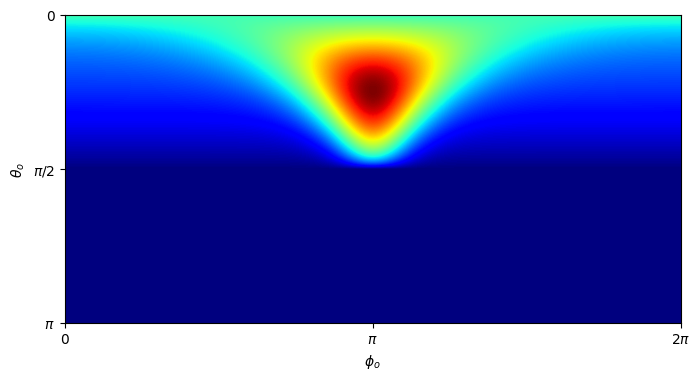

In [5]:
# Plot eval
plot_dist(np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0])


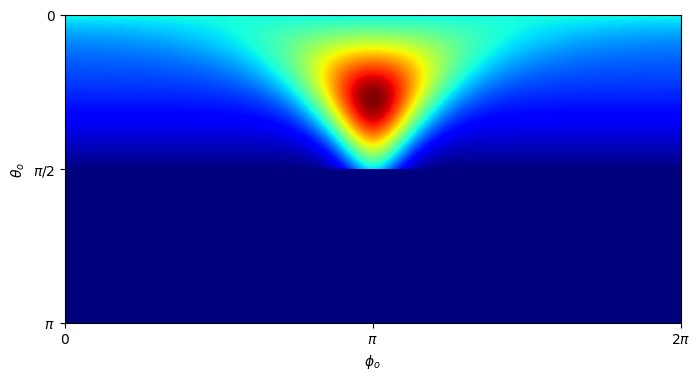

In [6]:
# Plot eval
plot_dist(np.array(bsdf.pdf(mi.BSDFContext(), si, wo)))

C:\Users\agruson\AppData\Local\Temp\ipykernel_34376\3959060315.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0] / np.array(bsdf.pdf(mi.BSDFContext(), si, wo))


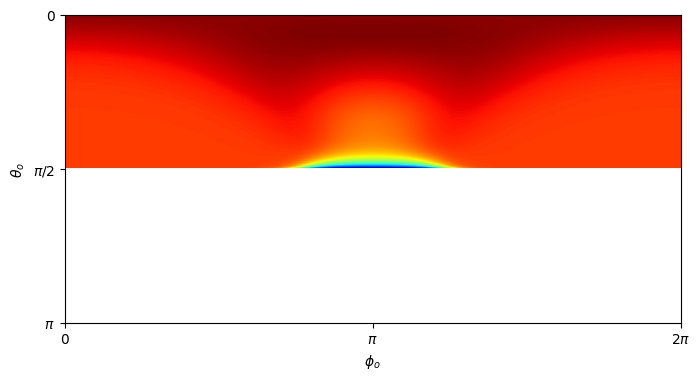

In [7]:
ratio = np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0] / np.array(bsdf.pdf(mi.BSDFContext(), si, wo))
plot_dist(ratio)

In [8]:
# <float name="roughness" value="0.05"/>
# <rgb name="albedo" value="1.0"/>
# <rgb name="specular" value="0.0"/>
xml = """""" 
sample_func, pdf_func = mi.chi2.BSDFAdapter("rednermat", xml)

chi2 = mi.chi2.ChiSquareTest(
    domain=mi.chi2.SphericalDomain(),
    sample_func=sample_func,
    pdf_func=pdf_func,
    sample_dim=3, # 3 random numbers
    ires=16,
    res=201
)

assert chi2.run()

chi2._dump_tables()

Pooled 500 low-valued cells into 182 cells to ensure sufficiently high expected cell frequencies
Histogram sum = 0.999487 (32.00 ms), PDF sum = 0.999512 (57.10 ms)
Chi^2 statistic = 9623.564142 (d.o.f = 9781)
Accepted the null hypothesis (p-value = 0.870120, significance level = 0.010000)



In [9]:
wi = dr.normalize(mi.Vector3f([0.2, 0.6, 0.5]))
sample_func, pdf_func = mi.chi2.BSDFAdapter("rednermat", xml, wi=wi)
chi2 = mi.chi2.ChiSquareTest(
    domain=mi.chi2.SphericalDomain(),
    sample_func=sample_func,
    pdf_func=pdf_func,
    sample_dim=3, # 3 random numbers
    ires=16,
    res=201
)

assert chi2.run()

chi2._dump_tables()

Pooled 476 low-valued cells into 161 cells to ensure sufficiently high expected cell frequencies
Histogram sum = 0.960242 (32.00 ms), PDF sum = 0.960200 (64.97 ms)
Chi^2 statistic = 9922.557627 (d.o.f = 9784)
Accepted the null hypothesis (p-value = 0.160933, significance level = 0.010000)

